# Data Mining Lab 1 - Third HW

This file is the third assignment, which uncluding the fllowing:
1. Generate meaningful new data visualizations.
2. Generate TF-IDF features from the tokens of each text. This will generating a document matrix, however, the weights will be computed differently (using the TF-IDF value of each word per document as opposed to the word frequency).
3. Implement a simple Naive Bayes classifier that automatically classifies the records into their categories. Use both the TF-IDF features and word frequency features to build two seperate classifiers.

\ Required Libraries \

In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

In [33]:
# read the csv file
def read_file(data_dir):
    data = pd.read_csv(data_dir)
    return data

# Load Data
data_path = '/Users/aping/PycharmProjects/DM2024-Lab1/Lab1 Handout/DM2024-Lab1-Homework/nostalgia_csv/Nostalgic_Sentiment_Analysis_of_YouTube_Comments_Data.csv'
data = read_file(data_path)

In [34]:
# 讀取我的資料跟欄位，設定datapath & radomstate
def fetch_custom_data(data, categories):
    filtered_data = data[data['sentiment'].isin(categories)]
    train_data, test_data = train_test_split(filtered_data, test_size=0.2, random_state=42)
    return train_data, test_data

categories = ['not nostalgia', 'nostalgia']
train_data, test_data = fetch_custom_data(data, categories)

In [35]:
import helpers.data_mining_helpers as dmh

# Apply formatting function to sentiment and comment columns
x1 = pd.DataFrame.from_records(dmh.format_rows_revise(train_data, 'sentiment'), columns=['sentiment'])
x2 = pd.DataFrame.from_records(dmh.format_rows_revise(train_data, 'comment'), columns=['comment'])

# Concatenate formatted data
X = pd.concat([x1, x2], axis=1)

*** Step 1: Generate Meaningful Data Visualizations ***

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

sentiment
not nostalgia    602
nostalgia        598
Name: count, dtype: int64


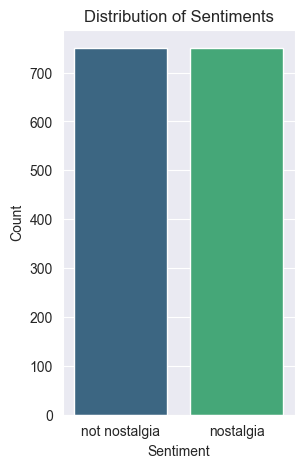

In [37]:
print(X.sentiment.value_counts())

# Visualize the distribution of sentiment labels
plt.figure(figsize=(3,5))
sns.countplot(data=data, x='sentiment', hue='sentiment', palette='viridis', legend=False)
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [38]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
#learn the vocabulary and return document-term matrix
X_counts = count_vect.fit_transform(X.comment) 

In [39]:
# test 
analyze = count_vect.build_analyzer()
# test analyze
analyze(X.comment[1])

['the',
 'most',
 'underrated',
 'singer',
 'ever',
 'beautiful',
 'song',
 'billy',
 'what',
 'fabulous',
 'voice']

In [40]:
import numpy as np

# Aggregate term frequencies by summing across all documents
term_frequencies = []

for j in range(0,X_counts.shape[1]):
    term_frequencies.append(sum(X_counts[:,j].toarray()))
    
term_frequencies = np.asarray(X_counts.sum(axis=0))[0]
term_frequencies[0] #sum of first term: 00

2

In [41]:
count_vect.get_feature_names_out()[0:10]

array(['000', '045', '07', '10', '100', '10m', '11', '11th', '12', '13'],
      dtype=object)

In [42]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

# 假設 X 是包含評論和情感類別的 DataFrame
# 將資料分成 'nostalgia' 和 'not nostalgia' 類別
nostalgia_comments = X[X['sentiment'] == 'nostalgia']['comment']
not_nostalgia_comments = X[X['sentiment'] == 'not nostalgia']['comment']

# 初始化 CountVectorizer，不移除停用詞
vectorizer = CountVectorizer()

# 對 'nostalgia' 類別進行詞頻計算
nostalgia_matrix = vectorizer.fit_transform(nostalgia_comments)
nostalgia_freq = dict(zip(vectorizer.get_feature_names_out(), nostalgia_matrix.sum(axis=0).A1))

# 對 'not nostalgia' 類別進行詞頻計算
not_nostalgia_matrix = vectorizer.fit_transform(not_nostalgia_comments)
not_nostalgia_freq = dict(zip(vectorizer.get_feature_names_out(), not_nostalgia_matrix.sum(axis=0).A1))

# 將詞頻轉換為 DataFrame，方便比較
nostalgia_df = pd.DataFrame(list(nostalgia_freq.items()), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)
not_nostalgia_df = pd.DataFrame(list(not_nostalgia_freq.items()), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)

In [43]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Create separate DataFrames for each category
categories = X['sentiment'].unique()  # Get unique category labels
category_dfs = {}  # Dictionary to store DataFrames for each category

for category in categories:
    # Filter the original DataFrame by category
    category_dfs[category] = X[X['sentiment'] == category].copy()

# Function to create term-document frequency DataFrame for each category
def create_term_document_df(df):
    count_vect = CountVectorizer()  # Initialize the CountVectorizer
    X_counts = count_vect.fit_transform(df['comment'])  # Transform the text data into word counts
    
    # Get the unique words (vocabulary) from the vectorizer
    words = count_vect.get_feature_names_out()
    
    # Create a DataFrame where rows are documents and columns are words
    term_document_df = pd.DataFrame(X_counts.toarray(), columns=words)
    
    return term_document_df

# Create term-document frequency DataFrames for each category
filt_term_document_dfs = {}  # Dictionary to store term-document DataFrames for each category

for category in categories:
    filt_term_document_dfs[category] = create_term_document_df(category_dfs[category])

In [44]:
# 獲取所有情感類別
sentiment = X['sentiment'].unique()  # ['nostalgia', 'not nostalgia']
sentiment_dfs={}
category_number = 0 #not n

# Filter the bottom 1% and top 5% words based on their sum across all documents
def filter_top_bottom_words_by_sum(term_document_df, top_percent=0.05, bottom_percent=0.01):
    # Calculate the sum of each word across all documents
    word_sums = term_document_df.sum(axis=0)
    
    # Sort the words by their total sum
    sorted_words = word_sums.sort_values()
    
    # Calculate the number of words to remove
    total_words = len(sorted_words)
    top_n = int(top_percent * total_words)
    bottom_n = int(bottom_percent * total_words)
    
    # Get the words to remove from the top 5% and bottom 1%
    words_to_remove = pd.concat([sorted_words.head(bottom_n), sorted_words.tail(top_n)]).index
    
    # Print the words that are being removed for reference
    print(f'Bottom {bottom_percent * 100}% words: \n{sorted_words.head(bottom_n)}')
    print(f'Top {top_percent * 100}% words: \n{sorted_words.tail(top_n)}')
    
    # Return the DataFrame without the filtered words
    return term_document_df.drop(columns=words_to_remove)

# Apply the filtering function to each category DataFrame
filtered_term_document_dfs = {}

for category in categories:
    print(f"Filtering words for category '{category}':")
    filtered_term_document_dfs[category] = filter_top_bottom_words_by_sum(filt_term_document_dfs[category])

# Example: Display the filtered DataFrame for one of the categories
category_to_display = 'nostalgia'  # Replace with the desired category name if needed
if category_to_display in filtered_term_document_dfs:
    print(f"Filtered Term-Document Frequency DataFrame for Category '{category_to_display}':")
    print(filtered_term_document_dfs[category_to_display])
else:
    print(f"Category '{category_to_display}' not found.")

Filtering words for category 'nostalgia':
Bottom 1.0% words: 
yup              1
rolled           1
grand            1
grammartical     1
gramaphone       1
rolling          1
graffiti         1
grandchildren    1
graduation       1
gradually        1
romanticism      1
grace            1
grabbed          1
ronnie           1
gospel           1
romance          1
rose             1
roll             1
robbie           1
dtype: int64
Top 5.0% words: 
passed     28
really     28
happy      28
day        28
ago        30
         ... 
and       383
to        429
this      445
my        448
the       519
Length: 99, dtype: int64
Filtering words for category 'not nostalgia':
Bottom 1.0% words: 
leader           1
muchm            1
ms               1
mph              1
moving           1
motor            1
mornings         1
morning          1
moral            1
moodier          1
mood             1
monumental       1
montgomery       1
money            1
monday           1
moments          

Generating Word-Sentiment Association Network Graph for 'nostalgia':


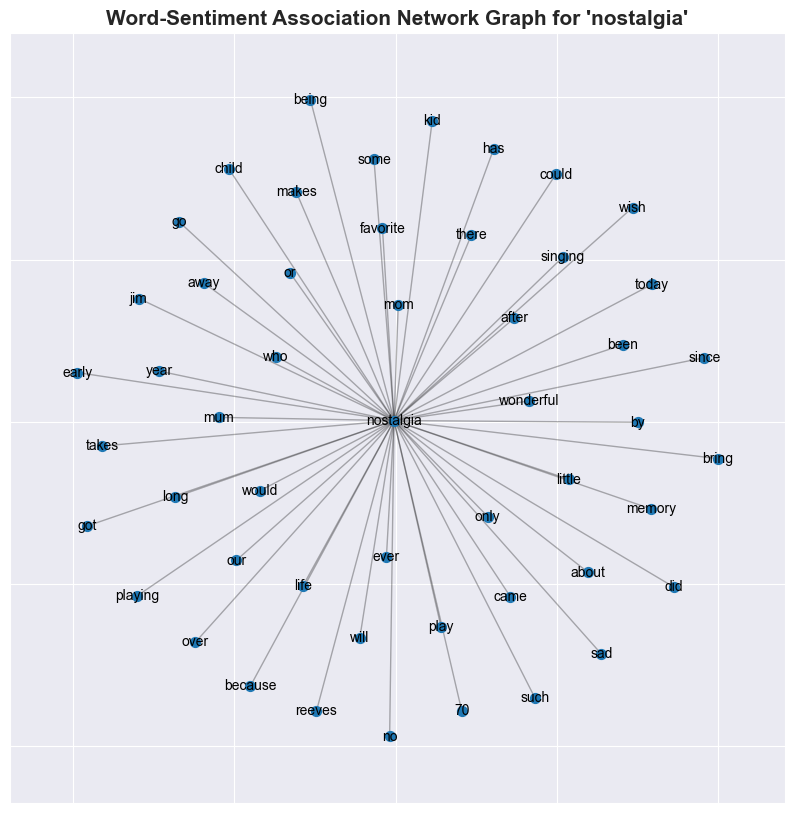

Generating Word-Sentiment Association Network Graph for 'not nostalgia':


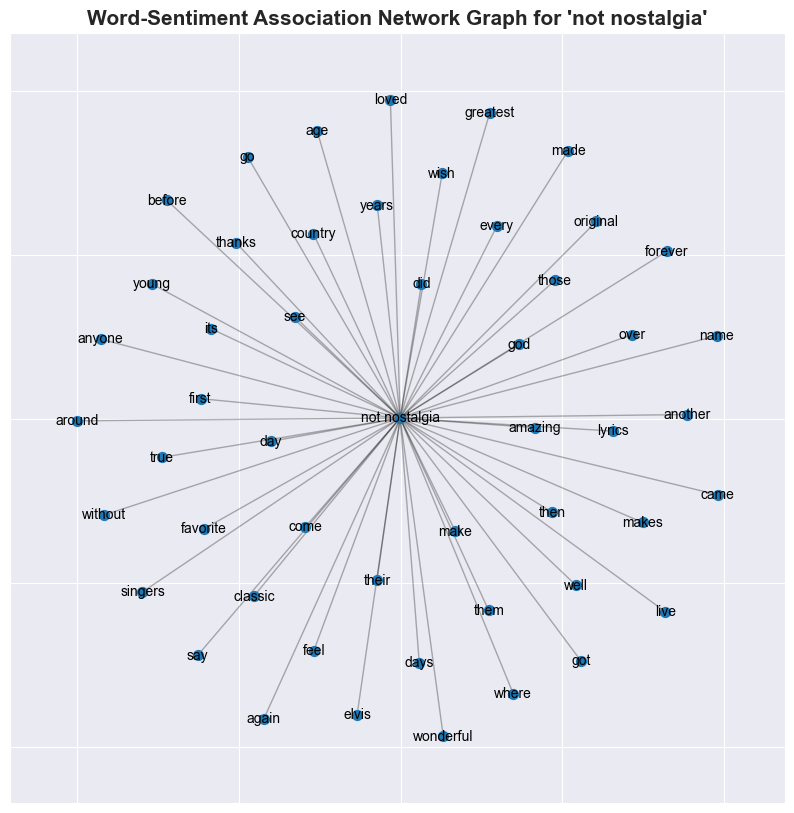

Filtered Term-Document Frequency DataFrame for Category 'nostalgia':
     07  10  11  11th  12  13  14  15  16  17  ...  yo  yokel  younger  \
0     0   0   0     0   0   0   0   0   0   0  ...   0      0        0   
1     0   0   0     0   0   0   0   0   0   0  ...   0      0        0   
2     0   0   0     0   0   0   0   0   0   0  ...   0      0        0   
3     0   0   0     0   0   0   0   0   0   0  ...   0      0        0   
4     0   0   0     0   0   0   0   0   0   0  ...   0      0        0   
..   ..  ..  ..   ...  ..  ..  ..  ..  ..  ..  ...  ..    ...      ...   
593   0   1   0     0   0   0   0   1   0   0  ...   0      0        1   
594   0   0   0     0   0   0   0   0   0   0  ...   0      0        0   
595   0   0   0     0   0   0   0   0   0   0  ...   0      0        0   
596   0   0   0     0   0   0   0   0   0   0  ...   0      0        0   
597   0   0   0     0   0   0   0   0   0   0  ...   0      0        0   

     youngster  your  yours  youth  youthf

In [45]:
import networkx as nx
import matplotlib.pyplot as plt

# Generate Association Network Graph for 'nostalgia' and 'not nostalgia'
def generate_word_sentiment_association_network(category_df, category_name):
    # Calculate the correlation between words and sentiment
    word_sums = category_df.sum(axis=0)
    top_words = word_sums.nlargest(50)
    
    # Create the graph
    G = nx.Graph()
    for word, weight in top_words.items():
        if weight > 0:
            G.add_edge(word, category_name, weight=weight)
    
    # Draw the graph
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G, k=0.8, iterations=100)
    nx.draw_networkx_nodes(G, pos, node_size=50)
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif', font_color='black')
    plt.title(f"Word-Sentiment Association Network Graph for '{category_name}'", fontsize=15, fontweight='bold')
    plt.show()

# Generate the association network graphs for 'nostalgia' and 'not nostalgia'
if 'nostalgia' in filtered_term_document_dfs:
    print("Generating Word-Sentiment Association Network Graph for 'nostalgia':")
    generate_word_sentiment_association_network(filtered_term_document_dfs['nostalgia'], 'nostalgia')

if 'not nostalgia' in filtered_term_document_dfs:
    print("Generating Word-Sentiment Association Network Graph for 'not nostalgia':")
    generate_word_sentiment_association_network(filtered_term_document_dfs['not nostalgia'], 'not nostalgia')

# Example: Display the filtered DataFrame for one of the categories
category_to_display = 'nostalgia'  # Replace with the desired category name if needed
if category_to_display in filtered_term_document_dfs:
    print(f"Filtered Term-Document Frequency DataFrame for Category '{category_to_display}':")
    print(filtered_term_document_dfs[category_to_display])
else:
    print(f"Category '{category_to_display}' not found.")

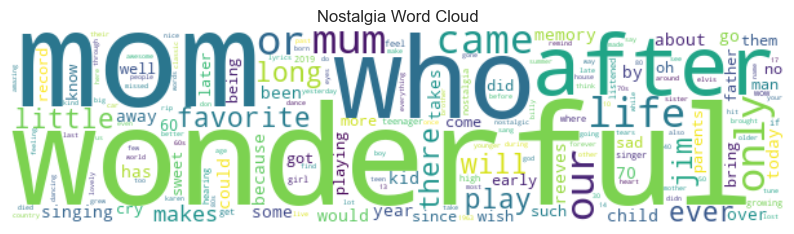

In [46]:
word_sums = filtered_term_document_dfs['nostalgia'].sum(axis=0)
wordcloud = WordCloud(width=600, height=150, background_color='white').generate_from_frequencies(word_sums)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nostalgia Word Cloud")
plt.show()

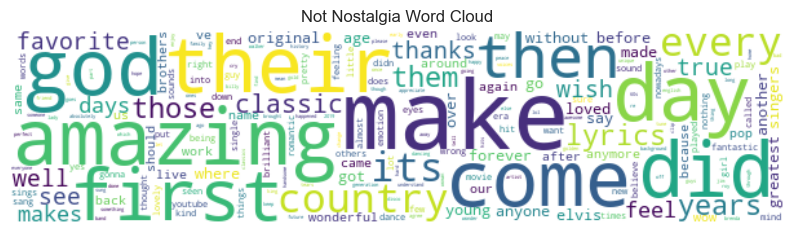

In [47]:
word_sums = filtered_term_document_dfs['not nostalgia'].sum(axis=0)
wordcloud = WordCloud(width=600, height=150, background_color='white').generate_from_frequencies(word_sums)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Not Nostalgia Word Cloud")
plt.show()

*** step2. Generate TF-IDF features from the tokens of each text.***

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [49]:
# Step 4: Extract comments for TF-IDF
comments = X['comment'].tolist() 

# Step 5: Create the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_train_matrix = tfidf_vectorizer.fit_transform(comments)

# Display the TF-IDF feature names and their respective scores
feature_names = tfidf_vectorizer.get_feature_names_out()

# Convert the matrix to an array and print scores
'''for i, comment in enumerate(comments):
    print(f"Comment {i+1}:")
    tfidf_scores = zip(feature_names, tfidf_matrix[i].toarray()[0])
    for word, score in tfidf_scores:
        if score > 0:  # Show only words that have a non-zero TF-IDF score
            print(f"    {word}: {score:.4f}")'''

# Optional: Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_train_matrix.toarray(), columns=feature_names)
print(tfidf_df)

      000  045   07        10  100  10m   11  11th   12   13  ...  yours  \
0     0.0  0.0  0.0  0.000000  0.0  0.0  0.0   0.0  0.0  0.0  ...    0.0   
1     0.0  0.0  0.0  0.000000  0.0  0.0  0.0   0.0  0.0  0.0  ...    0.0   
2     0.0  0.0  0.0  0.000000  0.0  0.0  0.0   0.0  0.0  0.0  ...    0.0   
3     0.0  0.0  0.0  0.000000  0.0  0.0  0.0   0.0  0.0  0.0  ...    0.0   
4     0.0  0.0  0.0  0.000000  0.0  0.0  0.0   0.0  0.0  0.0  ...    0.0   
...   ...  ...  ...       ...  ...  ...  ...   ...  ...  ...  ...    ...   
1195  0.0  0.0  0.0  0.146376  0.0  0.0  0.0   0.0  0.0  0.0  ...    0.0   
1196  0.0  0.0  0.0  0.000000  0.0  0.0  0.0   0.0  0.0  0.0  ...    0.0   
1197  0.0  0.0  0.0  0.000000  0.0  0.0  0.0   0.0  0.0  0.0  ...    0.0   
1198  0.0  0.0  0.0  0.000000  0.0  0.0  0.0   0.0  0.0  0.0  ...    0.0   
1199  0.0  0.0  0.0  0.000000  0.0  0.0  0.0   0.0  0.0  0.0  ...    0.0   

      yourself  youth  youthful  youtube  yrs  yuo  yup  zealand  zulus  
0          0.

In [50]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

category_mapping = dict(X[['sentiment', 'comment']].drop_duplicates().values)
target_names = [category_mapping[label] for label in sorted(category_mapping.keys())]

X_train, X_test, y_train, y_test = train_test_split(tfidf_df, X['sentiment'], test_size=0.3, random_state=42)

In [51]:
X_train

,000,045,07,10,100,10m,11,11th,12,13,...,yours,yourself,youth,youthful,youtube,yrs,yuo,yup,zealand,zulus
522,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
213,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.513326,0.0,0.0,0.0,0.0


In [54]:
import pandas as pd
from sklearn.metrics import classification_report

# Train the Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = nb_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
report_dict = classification_report(y_test, y_pred, target_names=target_names, digits=4, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Print evaluation results
print("\n================ Evaluation Results(TF-IDF) ================")
print(f"Accuracy: {accuracy:.4f}\n")
print("Classification Report:\n")
print(report_df)
print("\n============================================================\n")


================ Evaluation Results(TF-IDF) ================
Accuracy: 0.8833

Classification Report:

                                                    precision    recall  \
Come back, please come back my old memories or ...   0.830918  0.960894   
She sounds like an old friend. I mean, a really...   0.954248  0.806630   
accuracy                                             0.883333  0.883333   
macro avg                                            0.892583  0.883762   
weighted avg                                         0.892926  0.883333   

                                                    f1-score     support  
Come back, please come back my old memories or ...  0.891192  179.000000  
She sounds like an old friend. I mean, a really...  0.874251  181.000000  
accuracy                                            0.883333    0.883333  
macro avg                                           0.882722  360.000000  
weighted avg                                        0.882675  360.0000

frequency counter

In [55]:
# Convert 'comment' column into term-document matrix using CountVectorizer
count_vect = CountVectorizer()
X_tdm = count_vect.fit_transform(X['comment'])  # 'comment' column contains the text data
terms = count_vect.get_feature_names_out()  # Original terms in the vocabulary

# Tokenize the sentences into sets of unique words
X['tokenized_text'] = X['comment'].str.split().apply(set)

# Convert the term-document matrix to a DataFrame for easy merging
tdm_df = pd.DataFrame(X_tdm.toarray(), columns=terms, index=X.index)

In [56]:
#Model with only the document-term frequency data
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# Create a mapping from numerical labels to category names
category_mapping_fre = dict(X[['sentiment', 'comment']].drop_duplicates().values)

# Convert the numerical category labels to text labels
target_names_fre = [category_mapping_fre[label] for label in sorted(category_mapping.keys())]

# Split data into training and testing sets
X_train_fre, X_test_fre, y_train_fre, y_test_fre = train_test_split(tdm_df, X['sentiment'], test_size=0.3, random_state=42)

In [57]:
import pandas as pd
from sklearn.metrics import classification_report

# Train the Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_fre, y_train_fre)

# Make predictions on the test set
y_pred_fre = nb_classifier.predict(X_test_fre)

# Evaluate the classifier
accuracy_fre = accuracy_score(y_test_fre, y_pred_fre)
report_dict_fre = classification_report(y_test_fre, y_pred_fre, target_names=target_names, digits=4, output_dict=True)
report_df_fre = pd.DataFrame(report_dict_fre).transpose()

# Print evaluation results
print("\n================ Evaluation Results(frequency count) ================")
print(f"Accuracy: {accuracy_fre:.4f}\n")
print("Classification Report:\n")
print(report_df_fre)
print("\n=====================================================================\n")


================ Evaluation Results(frequency count) ================
Accuracy: 0.8972

Classification Report:

                                                    precision    recall  \
Come back, please come back my old memories or ...   0.851485  0.960894   
She sounds like an old friend. I mean, a really...   0.955696  0.834254   
accuracy                                             0.897222  0.897222   
macro avg                                            0.903591  0.897574   
weighted avg                                         0.903880  0.897222   

                                                    f1-score     support  
Come back, please come back my old memories or ...  0.902887  179.000000  
She sounds like an old friend. I mean, a really...  0.890855  181.000000  
accuracy                                            0.897222    0.897222  
macro avg                                           0.896871  360.000000  
weighted avg                                        0.896838 